In [1]:
import argparse
import numpy as np
from get_data import main
from cnn.training import get_trained_model
import matplotlib.pyplot as plt
import warnings
#from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
#plt.style.use('ggplot')

In [8]:
!pip install hyperopt

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', help='Path to the config file', default='./default_config.yml')
parser.add_argument('--log-dir', help='Path to the log directory', default='../log/')
parser.add_argument('--posters', help='Path to the posters', default='../data/posters/')
parser.add_argument('--models-dir', help='Path to the saved models', default='../data/models/')
parser.add_argument('--sets-dir', help='Path to the training and testing sets', default='../data/sets/')
parser.add_argument('--database', help='Path to the databse csv', default='../data/poster_data.csv')
parser.add_argument('--csv', help='Path to the clean csv', default='../data/')
parser.add_argument('-s', '--save', help='Save model', action='store_true')
parser.add_argument('-v', '--verbose', help='Verbose', action='store_true')

str_args = '-v -s'.split()
args, _ = parser.parse_known_args(str_args)

In [3]:
clean_movies, train_posters, train_genres, train_ids, test_posters, test_genres, test_ids, model_name, save_model, verbose = main(args)

  2%|█▎                                                                          | 206/11935 [00:00<00:05, 2040.60it/s]

Database already cleaned
Posters database downloading


 85%|██████████████████████████████████████████████████████████████▌           | 10099/11935 [00:03<00:00, 3060.27it/s]

Error HTTP Error 404: Not Found with film 9532


100%|██████████████████████████████████████████████████████████████████████████| 11935/11935 [00:03<00:00, 3126.62it/s]


Database downloaded
Training and testing sets already made


In [5]:
resnet, _ = get_trained_model(model_name)

Loading keras ResNet50V2


In [6]:
train_features_resnet = resnet.predict(train_posters).reshape((len(train_posters), -1))
test_features_resnet = resnet.predict(test_posters).reshape((len(test_posters), -1))

# PCA

In [7]:
from sklearn.decomposition import PCA

pca_resnet = PCA(n_components=0.95)

In [8]:
from sklearn.preprocessing import StandardScaler

SC = StandardScaler()
SC.fit(train_features_resnet)
train_features_resnet_stand = SC.transform(train_features_resnet)
test_features_resnet_stand = SC.transform(test_features_resnet)

In [9]:
pca_resnet.fit(train_features_resnet)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
train_resnet_pca = pca_resnet.transform(train_features_resnet)
test_resnet_pca = pca_resnet.transform(test_features_resnet)

#train_resnet_pca = pca_resnet.transform(train_features_resnet_stand)
#test_resnet_pca = pca_resnet.transform(test_features_resnet_stand)

In [10]:
print(train_features_resnet.shape[1], train_resnet_pca.shape[1])

32768 2178


# KNN 

In [28]:
from knn.knn import KNN

k = 3
knn = KNN(k)
knn.fit(train_resnet_pca, train_genres)

KNN(n_neighbors=3, verbose=True, weights='distance')

In [29]:
from utils.accuracy import mono_label

predicted_genres = knn.predict(test_resnet_pca, train_genres)
acc = mono_label(train_genres, predicted_genres)
print('Accuracy:', acc)

  0%|                                                                                 | 6/4165 [00:00<01:18, 53.22it/s]

Predicting...


100%|██████████████████████████████████████████████████████████████████████████████| 4165/4165 [01:20<00:00, 52.00it/s]

Prediction done
Accuracy: 0.56062424969988


# XGBoost

Lien pour avoir accès à la courbe de loss : https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

In [ ]:
from xgboost import XGBClassifier, plot_tree

train_genres_flat = np.array([np.nonzero(x)[0] for x in train_genres]).squeeze()
test_genres_flat = np.array([np.nonzero(x)[0] for x in test_genres]).squeeze()

Le bloc suivant calcule le classifier optimal sur la search grid optimal:

pour les hyperparamètres de base :https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

In [1]:
boost = XGBClassifier(objective='multi:softmax', num_classes=7)
boost.fit(train_resnet_pca, train_genres_flat, eval_metric=["merror", "mlogloss"], eval_set=[(train_resnet_pca, train_genres_flat), (test_resnet_pca, test_genres_flat)])

train_genres_flat = np.array([np.nonzero(x)[0] for x in train_genres]).squeeze()
test_genres_flat = np.array([np.nonzero(x)[0] for x in test_genres]).squeeze()


def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree'],
                            num_classes=7
                            )
    
    classifier.fit(train_resnet_pca, train_genres_flat)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = train_resnet_pca, y = train_genres_flat, cv = 10)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }

space = {
    'max_depth' : hp.choice('max_depth', range(3, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

#space = {
#    'max_depth' : hp.choice('max_depth', range(4, 5, 1)),
#    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.03, 0.01),
#    'n_estimators' : hp.choice('n_estimators', range(90, 105, 5)),
#    'gamma' : hp.quniform('gamma', 0.9, 0.92, 0.01),
#    'min_child_weight' : hp.quniform('min_child_weight', 1, 3, 1),
#    'subsample' : hp.quniform('subsample', 0.8, 0.82, 0.01),
#    'colsample_bytree' : hp.quniform('colsample_bytree', 0.9, 0.92, 0.01)}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best: ", best)

NameError: name 'XGBClassifier' is not defined

In [ ]:
# Fitting XGBoost to the Training set
boost = XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree'],
                            num_classes=7
                     )

boost.fit(train_resnet_pca, train_genres_flat, eval_metric=["merror", "mlogloss"], eval_set=[(train_resnet_pca, train_genres_flat), (test_resnet_pca, test_genres_flat)])

Si on veut calculer un arbre sans l'optimisation des hyperparamètres.

In [ ]:
boost = XGBClassifier(objective='multi:softmax', num_classes=7)
boost.fit(train_resnet_pca, train_genres_flat, eval_metric=["merror", "mlogloss"], eval_set=[(train_resnet_pca, train_genres_flat), (test_resnet_pca, test_genres_flat)])

In [ ]:
predicted_genres = boost.predict(test_resnet_pca)
test_genres_flat = np.array([np.nonzero(x)[0] for x in test_genres]).squeeze()

In [ ]:
# retrieve performance metrics
results = boost.evals_result()
epochs = len(results['validation_0']['merror'])
print(epochs)
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
# plot log loss
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.grid("True")
ax.legend()
plt.show()


# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.grid("True")
ax.legend()
plt.show()

#### performance

In [ ]:
boost.save_model('current.model')
print("accuracy : ", np.mean(test_genres_flat == predicted_genres))

In [ ]:
predicted_genres_matrix = np.zeros((len(predicted_genres), 7))
for i in range(len(predicted_genres)):
    predicted_genres_matrix[i][predicted_genres[i]] = 1

In [ ]:
ConfusionMatrix_display(test_genres, predicted_genres_matrix, config['genres'], "Performance du random_forest")

#### features d'intérêt

In [ ]:
plt.bar(range(len(boost.feature_importances_)), boost.feature_importances_)
plt.show()
print(np.sum(boost.feature_importances_))

#### Affichage de l'arbre

In [ ]:
plot_tree(boost)
fig = plt.gcf()
fig.set_size_inches(300, 150)

#double click pour la visualisation

# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier # Regarder les autres multiclass possibles
# J'ai testé vite fait OneVsOne: pb de dimension, autre format d'input attendu

svc = OneVsRestClassifier(SVC(gamma='auto'))
svc.fit(train_resnet_pca, train_genres)

In [ ]:
from utils.accuracy import mono_label

predicted_genres = svc.predict(test_resnet_pca)
acc = mono_label(test_genres, predicted_genres)

# Analyse des résultats

In [14]:
import yaml

config = yaml.safe_load(open(args.config))
class_names = {config['genres'][k]: k for k in config['genres'].keys()}

['Action', 'Animation', 'ComÃ©die', 'ComÃ©die dramatique', 'Documentaire', 'Drame', 'Thriller-Policier']


array([[0.8605042 , 0.03529412, 0.02857143, 0.00672269, 0.02184874,
        0.01512605, 0.03193277],
       [0.0907563 , 0.84033613, 0.01848739, 0.01176471, 0.02521008,
        0.00840336, 0.00504202],
       [0.10084034, 0.19495798, 0.6302521 , 0.02521008, 0.02184874,
        0.01344538, 0.01344538],
       [0.1210084 , 0.18319328, 0.14957983, 0.46890756, 0.04369748,
        0.02016807, 0.01344538],
       [0.11596639, 0.17478992, 0.09915966, 0.0907563 , 0.47731092,
        0.01848739, 0.02352941],
       [0.13445378, 0.16302521, 0.11932773, 0.1210084 , 0.08739496,
        0.34789916, 0.02689076],
       [0.17647059, 0.13613445, 0.13109244, 0.11260504, 0.11260504,
        0.03193277, 0.29915966]])

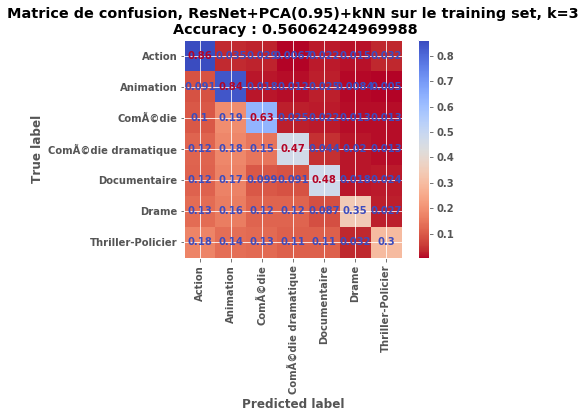

In [30]:
from utils.display.results_display import ConfusionMatrix_display

title = 'ResNet+PCA(0.95)+kNN, k='+str(k)+'\n Accuracy : '+ str(acc)
ConfusionMatrix_display(test_genres, predicted_genres, config['genres'], title)

In [ ]:
from utils.display.results_display import histogram

histogram(test_genres, predicted_genres, k, config['genres'])

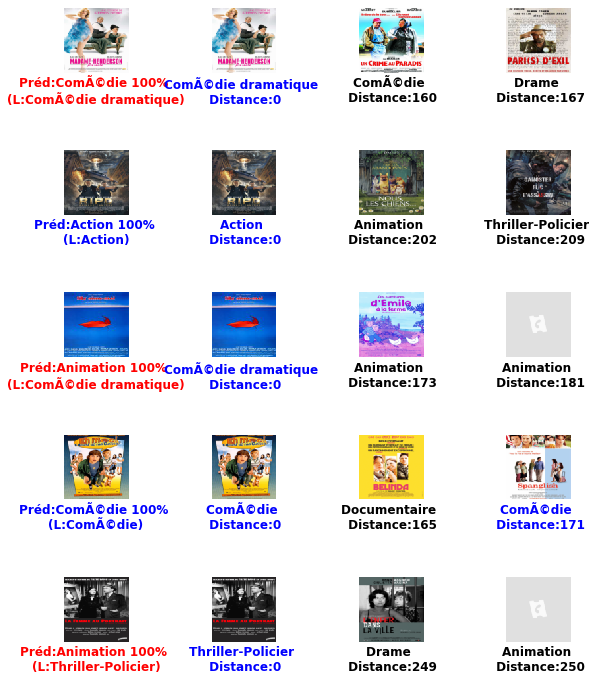

In [31]:
from utils.display.results_display import plot_neighbors
%matplotlib inline

starting_index = np.random.randint(0, 700)
num_images = 5
#plot_neighbors(test_posters, test_genres, class_names, predicted_genres, starting_index, num_images, train_posters, train_genres, knn.neighbors, knn.distances, method_for_title='ResNet+kNN')
plot_neighbors(train_posters, train_genres, class_names, predicted_genres, starting_index, num_images, train_posters, train_genres, knn.neighbors, knn.distances, method_for_title='')

Affichage de la matrice de confusion

## PCA 2D

In [ ]:
import matplotlib.pyplot as plt

def display2D(X_ortho, Y):
    colors = Y.argmax(axis=1)
    
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(X_ortho[:, 0], X_ortho[:, 1], c=colors)
    plt.legend(*scatter.legend_elements())
    
    plt.show(fig)

In [ ]:
pca = PCA(n_components=2)
# pca.fit(train_posters.reshape(len(train_posters), -1))

train_pca = pca.transform(train_posters.reshape(len(train_posters), -1))
# test_pca = pca.transform(test_posters.reshape(len(train_posters), -1))

display2D(train_pca, train_genres)
display2D(train_resnet_pca[:, :2], train_genres)

#Attention: l'erreur dans la VM vient de la version de matplotlib; et upgrade vers matplotlib 3.1.X pas possible
#Changer version Python...